# Maine Wildfire Analysis Notebook

### Author: Justin Baker
### Date: September 2023

### Description:
This script visualizes wildfire locations in Maine and summarizes
wildfire counts by county using GeoPandas. It produces both static
maps and an interactive HTML map.

In [49]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

####  Configuration

In [ ]:
CRS = "EPSG:2802"  # Maine State Plane (meters)

FIRE_DATA = Path("../data/raw/Fires.json")
STATE_DATA = Path("../data/raw/gz_2010_us_040_00_500k.json")
COUNTY_DATA = Path("../data/raw/Counties.geojson")

PROCESSED_MAINE_BOUNDARY = Path("../data/processed/maine_boundary.gpkg")
PROCESSED_COUNTIES = Path("../data/processed/maine_counties.gpkg")
WILDFIRES_BY_COUNTY_FIGURE = Path("./outputs/figures/wildfires_by_county_2022.png")
WILDFIRE_LOCATIONS_FIGURE = Path("./outputs/figures/wildfire_locations_2022.png")
OUTPUT_HTML = Path("../outputs/fires_explore.html")

#### Export Function

In [51]:
def export_geodataframe(
    gdf: gpd.GeoDataFrame,
    output_path: Path,
    layer_name: str | None = None
) -> None:
    '''
    Export a GeoDataFrame to disk, creating parent directories if needed.
    '''
    
    output_path.parent.mkdir(parents=True, exist_ok=True)

    if output_path.suffix == ".gpkg":
        gdf.to_file(output_path, layer=layer_name, driver="GPKG")
    else:
        gdf.to_file(output_path)

    print(f"Exported: {output_path}")

#### Data Loading Functions

In [52]:
def load_wildfires(path: Path, crs: str) -> gpd.GeoDataFrame:
    '''Load wildfire point data and project to the target CRS.'''
    
    return gpd.read_file(path).to_crs(crs)


def load_maine_boundary(
        path: Path,
        crs: str,
        export: bool = True
) -> gpd.GeoDataFrame:
    '''
    Load U.S. state boundaries and extract Maine, and optionally export
    the processed boundary.
    '''

    states = gpd.read_file(path).to_crs(crs)
    maine = states.loc[states["NAME"] == "Maine"]

    if export:
        export_geodataframe(
            maine,
            PROCESSED_MAINE_BOUNDARY,
            layer_name="maine_boundary"
        )
    return states.loc[states["NAME"] == "Maine"]


def load_counties(
    path: Path,
    crs: str,
    export: bool = True
) -> gpd.GeoDataFrame:
    '''
    Load Maine county boundaries and optionally export
    the processed dataset.
    '''

    counties = gpd.read_file(path).to_crs(crs)
    counties = counties[["name", "geometry"]]

    if export:
        export_geodataframe(
            counties,
            PROCESSED_COUNTIES,
            layer_name="maine_counties"
        )

    return counties

#### Analysis Functions

In [53]:
def calculate_fires_by_county(
    fires: gpd.GeoDataFrame,
    counties: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    """
    Spatially join wildfire points to counties and calculate
    fire counts per county.
    """
    joined = gpd.sjoin(
        fires,
        counties,
        predicate="within",
        how="inner"
    )

    fire_counts = (
        joined
        .groupby("name")
        .size()
        .reset_index(name="Number of Fires")
    )

    county_fires = counties.merge(
        fire_counts,
        on="name",
        how="left"
    )

    # Counties with no fires should display zero, not NaN
    county_fires["Number of Fires"] = (
        county_fires["Number of Fires"].fillna(0)
    )

    return county_fires

#### Visualization Functions

In [ ]:
def plot_wildfire_locations(
    maine: gpd.GeoDataFrame,
    fires: gpd.GeoDataFrame,
    output_path: Path
) -> None:
    """
    Create a static map of wildfire locations in Maine.
    """
    fig, ax = plt.subplots(figsize=(9, 9))

    maine.plot(
        ax=ax,
        color="lightgray",
        edgecolor="black"
    )

    fires.plot(
        ax=ax,
        color="red",
        markersize=5
    )

    cx.add_basemap(ax, crs=fires.crs)

    ax.set_title("Wildfire Locations in Maine (2022)")
    ax.axis("off")

    plt.savefig(output_path, dpi=300)
    plt.show()


def plot_fires_by_county(
    county_fires: gpd.GeoDataFrame,
    output_path: Path
) -> None:
    """
    Create a choropleth map showing wildfire counts per county.
    """
    fig, ax = plt.subplots(figsize=(9, 9))

    county_fires.plot(
        column="Number of Fires",
        cmap="Reds",
        legend=True,
        ax=ax,
        edgecolor="black"
    )

    ax.set_title("Maine Wildfires per County (2022)")
    ax.axis("off")

    plt.savefig(output_path, dpi=300)
    plt.show()


def export_interactive_map(
    county_fires: gpd.GeoDataFrame,
    output_path: Path
) -> None:
    """
    Export an interactive web map of wildfires per county.
    """
    m = county_fires.explore(
        column="Number of Fires",
        cmap="Reds",
        legend=True
    )

    m.save(output_path)
    print(f"Interactive map saved to: {output_path}")



#### Counties Debug

In [55]:
counties = gpd.read_file(COUNTY_DATA).to_crs(CRS)
counties.head()

,geo_point_2d,statefp,countyfp,countyns,geoid,name,namelsad,stusab,lsad,classfp,...,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,state_name,countyfp_nozero,geometry
0,"{'lon': -67.6090594873, 'lat': 44.9694591011}",23,029,00581300,23029,Washington,Washington County,ME,06,H1,...,NaN,NaN,A,6637431507,1799884965,+44.9670088,-067.6093542,Maine,29,"POLYGON ((333014.106 131547.927, 332996.178 13..."
1,"{'lon': -69.015547485, 'lat': 44.0272987421}",23,013,00581292,23013,Knox,Knox County,ME,06,H1,...,NaN,NaN,A,945697332,2017103596,+44.0420446,-069.0385145,Maine,13,"POLYGON ((234306.425 56569.494, 234131.270 571..."
2,"{'lon': -70.206444997, 'lat': 44.1658484298}",23,001,00581286,23001,Androscoggin,Androscoggin County,ME,06,H1,...,30340,NaN,A,1211990512,75546586,+44.1676811,-070.2074347,Maine,1,"POLYGON ((154133.467 61805.706, 154421.848 627..."
3,"{'lon': -69.5257592569, 'lat': 43.997787332}",23,015,00581293,23015,Lincoln,Lincoln County,ME,06,H1,...,NaN,NaN,A,1180688991,631299424,+43.9947814,-069.5136244,Maine,15,"POLYGON ((207410.896 51621.519, 207414.378 516..."
4,"{'lon': -70.6701460671, 'lat': 43.4292261998}",23,031,00581301,23031,York,York County,ME,06,H1,...,38860,NaN,A,2566874777,721658621,+43.4260188,-070.6684248,Maine,31,"POLYGON ((100212.024 -17710.475, 100222.311 -1..."


#### Main Workflow

Exported: ..\data\processed\maine_boundary.gpkg
Exported: ..\data\processed\maine_counties.gpkg


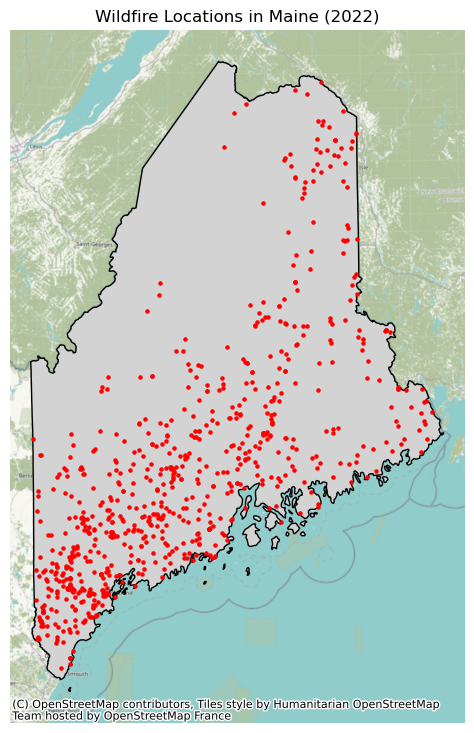

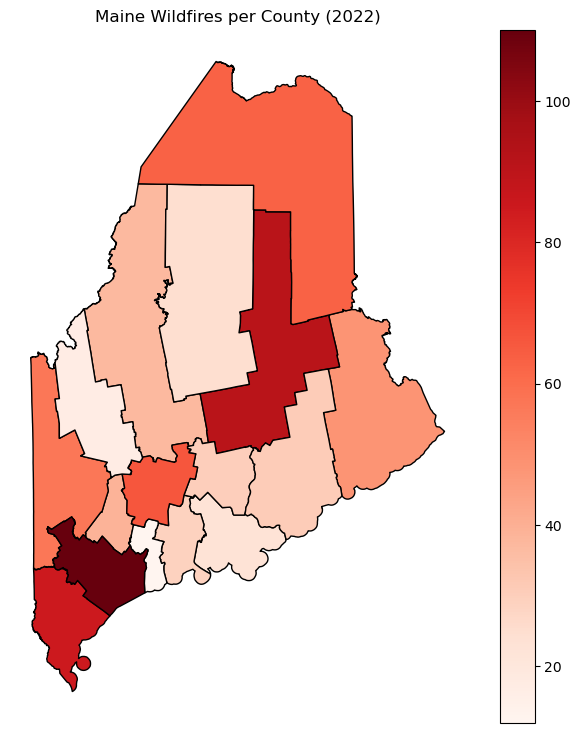

Interactive map saved to: ..\outputs\fires_explore.html


In [56]:
def main() -> None:
    """
    Execute the full GIS analysis workflow.
    """
    fires = load_wildfires(FIRE_DATA, CRS)
    maine = load_maine_boundary(STATE_DATA, CRS)
    counties = load_counties(COUNTY_DATA, CRS)

    plot_wildfire_locations(maine, fires)

    county_fires = calculate_fires_by_county(fires, counties)

    plot_fires_by_county(county_fires)
    export_interactive_map(county_fires, OUTPUT_HTML)

if __name__ == "__main__":
    main()